# Spaceship

## Task description

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

## File and Data Field Descriptions


### **train.csv**  - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

Destination - The planet the passenger will be debarking to.

Age - The age of the passenger.

VIP - Whether the passenger has paid for special VIP service during the voyage.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

Name - The first and last names of the passenger.

Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

### **test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data.

Your task is to predict the value of Transported for the passengers in this set.

### **sample_submission.csv** - A submission file in the correct format.

PassengerId - Id for each passenger in the test set.

Transported - The target. For each passenger, predict either True or False.

Here are the first 5 rows of the data:

In [142]:
# Load data
import pandas as pd

train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

data = pd.concat([train, test])

data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12970 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.5+ MB


**PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

The number of a passenger within their group is arbitrary, so we don't need it. However, group numbers may be important, so we'll create a new feature "Group".

In [144]:
data['Group'] = data['PassengerId'].str[:4]
print(data['Group'].info())
print(data['Group'].describe())
print('Unique Values:')
print(data['Group'].unique())

<class 'pandas.core.series.Series'>
Int64Index: 12970 entries, 0 to 4276
Series name: Group
Non-Null Count  Dtype 
--------------  ----- 
12970 non-null  object
dtypes: object(1)
memory usage: 202.7+ KB
None
count     12970
unique     9280
top        6499
freq          8
Name: Group, dtype: object
Unique Values:
['0001' '0002' '0003' ... '9271' '9273' '9277']


As we can see above, there are no missing values in Group.

Some other columns, though, have missing values. Let's explore if there are some patterns in missing data:

PassengerId        0
HomePlanet       288
CryoSleep        310
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      263
FoodCourt        289
ShoppingMall     306
Spa              284
VRDeck           268
Name             294
Transported     4277
Group              0
dtype: int64


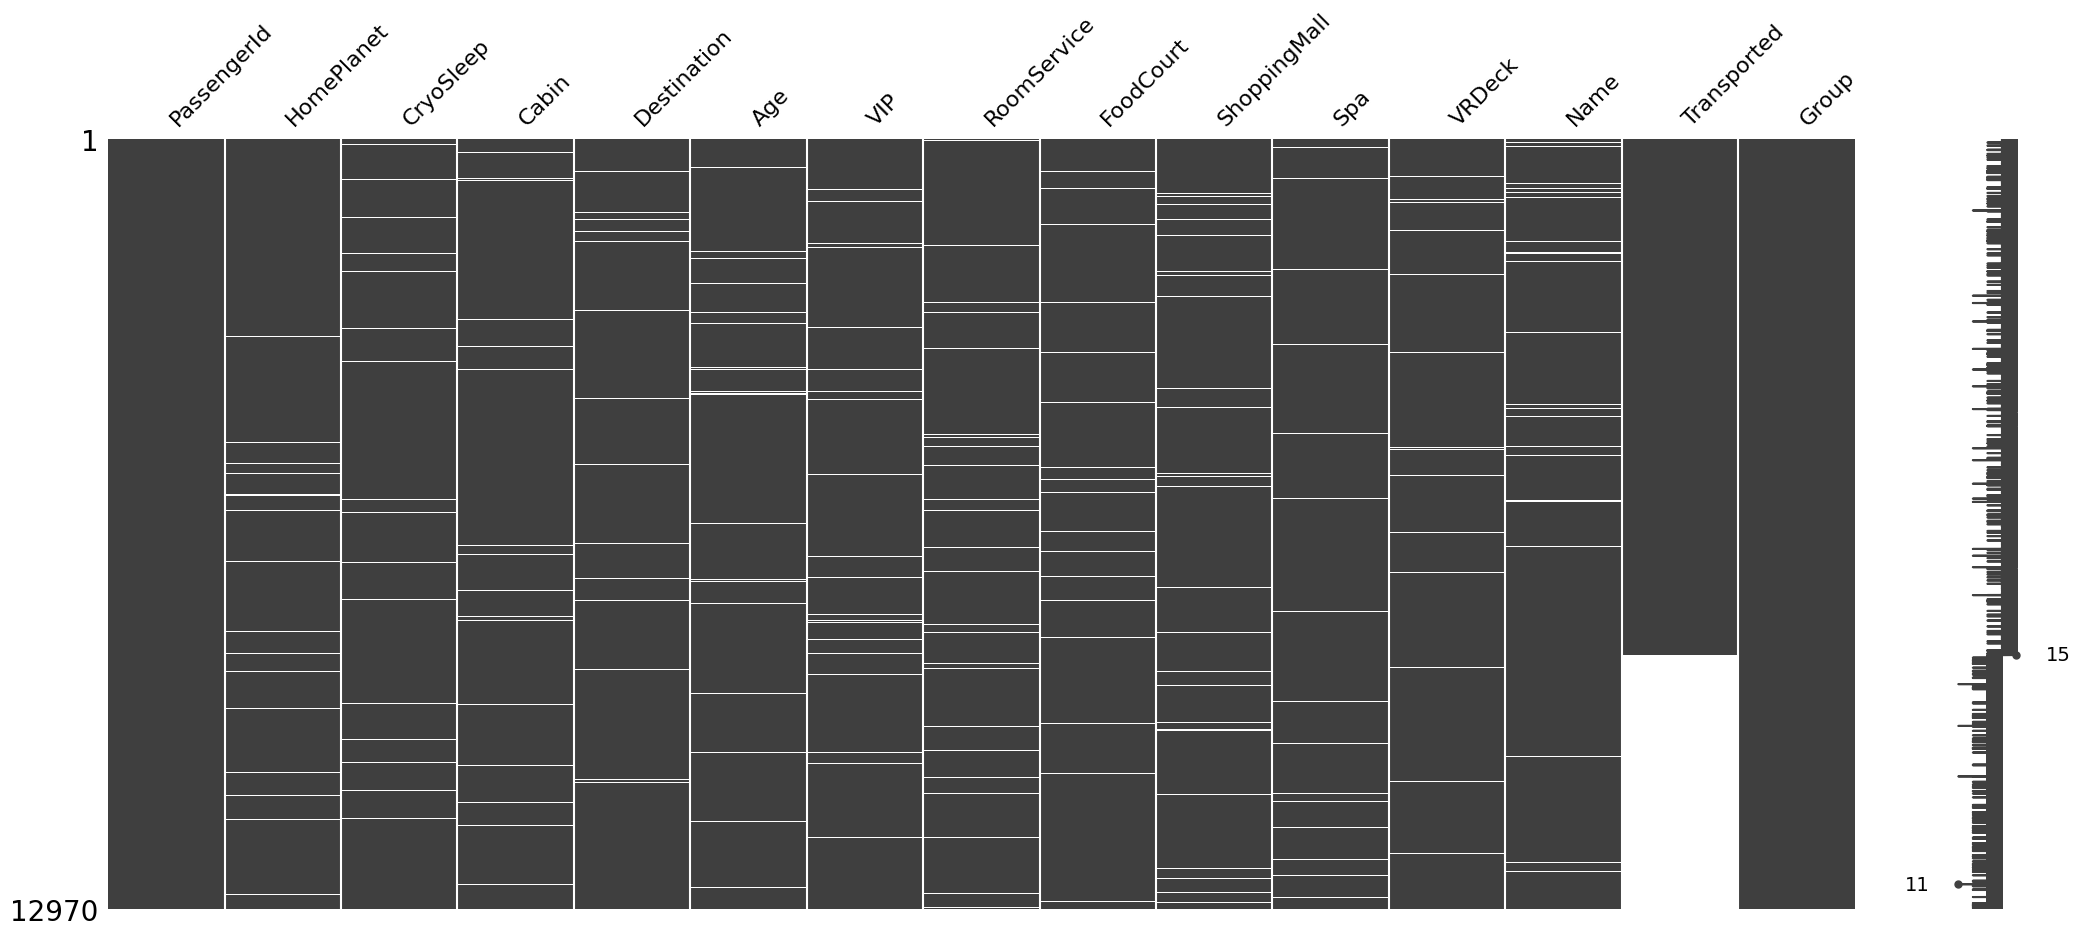

In [146]:
import missingno as msno
import matplotlib.pyplot as plt

# Print number of missing values in banking
print(data.isna().sum())

# Visualize missingness matrix
msno.matrix(data)
plt.show()

It seems that values are Missing At Random (Transported column is our target, it is missing in test data). We'll fill the missing values column by column, based on the description of the dataset.

**Name** - The first and last names of the passenger.

We don't need the first names, so we'll strip them. 
Additionally, we may assume that passengers with the same last names in different Groups are not relatives. To avoid treating them as relatives, we will append Group names to all last names:


In [135]:
### !!!! FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.

train.Name = train.Name.str.split(' ', 1).str[1]
train.Name = train.Name + train.Group

We'll fill the missing values for Names based on the most common surname in their Group.
If a passenger is alone in their group, we'll name them by the name of their Group:

In [136]:
# Iterate through all the rows with missing data
for index in train[train['Name'].isna()].index:
    # Fill the missing values for lonely passengers:
    if len(train[train['Group'] == train.loc[index, 'Group']]) == 1:
        train.loc[index, "Name"] = train.loc[index, 'Group']
    # Fill the missing values for non-lonely passengers:
    else:
        train.loc[index, "Name"] = train[(train['Group'] == train.loc[index, 'Group']) & \
                (train['Name'].isna() == False)]['Name'].mode()[0]

As you can see below, now Name doesn't have missing values:

In [137]:
print(train['Name'].info())
print(train['Name'].describe())
print('Unique Values:')
print(train['Name'].unique())

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: Name
Non-Null Count  Dtype 
--------------  ----- 
8693 non-null   object
dtypes: object(1)
memory usage: 68.0+ KB
None
count               8693
unique              6491
top       Clemondsey9081
freq                   8
Name: Name, dtype: object
Unique Values:
['Ofracculy0001' 'Vines0002' 'Susent0003' ... 'Mondalley9278' 'Connon9279'
 'Hontichre9280']


**HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.

**Destination** - The planet the passenger will be debarking to.

**VIP** - Whether the passenger has paid for special VIP service during the voyage.

It makes sense that these three features depend on Group and Name, so we'll fill the missing values accordingly. For lonely passengers, we'll fill these columns with the most common values:

In [ ]:
train.loc[]

In [80]:
# List of columns with missing values
columns_to_fill = ['HomePlanet', 'Destination', 'VIP']

# Iterate through all columns with missing values
for column in columns_to_fill:
    # Iterate through all the rows with missing data
    for index in train[train[column].isna()].index:
        print(index)
        # Fill the missing values for passengers alone in their group:
        if len(train[train['Group'] == train.loc[index, 'Group']]) == 1:
            train.loc[index, column] = train[column].mode()[0]
         # Fill the missing values for passengers with an unique last name:
        elif len(train[train['Name'] == train.loc[index, 'Name']]) == 1:
            train.loc[index, column] = train[(train['Group'] == train.loc[index, 'Group']) & \
                (train[column].isna() == False)]['Name'].mode()[0]
        # Fill the missing values for non-lonely passengers:
        else:
            train.loc[index, column] = train[(train['Group'] == train.loc[index, 'Group']) & \
                            (train['Name'] == train.loc[index, 'Name']) & \
                            (train[column].isna() == False)]['Name'].mode()[0]

59
113
186
225
234
274
286
291
347
365
405
407
438
471
481
501
505
524
568
637
737
807
848
920
962
993
999
1004
1024
1267
1307
1392
1399
1550
1600
1706
1714
1757
1807
1855
1892
1916
1926
2166
2173
2227
2233
2246
2274
2281
2290
2322
2324
2425
2442
2461
2502
2544
2617
2630
2631
2638
2642
2715
2749
2773
2791
2898
2926
2969
3091
3119
3168
3192
3277
3281
3326
3370
3433
3503
3535
3560
3595
3622
3635
3769
3816
3858
3891
3940
3946
3951
4025
4089
4097
4154
4172
4230
4315
4343
4366
4374
4535
4548
4581
4632
4702
4770
4817
4861
5016
5024
5055
5079
5081
5096
5101
5112
5208
5252
5316
5427
5438
5465
5576
5624
5634
5687
5689
5699
5723
5762
5904
5906
5953
5988
6004
6011
6030
6054
6056
6154
6169
6197
6205
6257
6267
6450
6565
6591
6609
6616
6622
6629
6644
6735
6737
6854
6913
6917


KeyError: 0